In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import Data

In [12]:
column_names = ['Year','Title', 'Origin', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot']
data = pd.read_csv('wiki_movie_plots_deduped.csv', names=column_names, skiprows=10000, nrows=4000)
data.head()

,Year,Title,Origin,Director,Cast,Genre,Wiki Page,Plot
0,1982,Parasite,American,Charles Band,"Demi Moore, Robert Glaudini",horror,https://en.wikipedia.org/wiki/Parasite_(film),"In the near future, an atomic disaster has red..."
1,1982,Partners,American,James Burrows,"John Hurt, Ryan O'Neal",comedy,https://en.wikipedia.org/wiki/Partners_(1982_f...,After a series of murders in Los Angeles's gay...
2,1982,Personal Best,American,Robert Towne,"Mariel Hemingway, Scott Glenn, Patrice Donnelly","drama, sports",https://en.wikipedia.org/wiki/Personal_Best_(f...,Chris Cahill is a young athlete who competes u...
3,1982,Poltergeist,American,Tobe Hooper,"Craig T. Nelson, Beatrice Straight, Dominique ...",horror,https://en.wikipedia.org/wiki/Poltergeist_(198...,Steven and Diane Freeling live a quiet life in...
4,1982,Porky's,American,Bob Clark,"Kim Cattrall, Mark Herrier, Wyatt Knight",comedy,https://en.wikipedia.org/wiki/Porky%27s,A group of Florida high school students plan o...


# Removing Columns

In [13]:
columns_to_remove = ['Cast','Wiki Page','Director']
data = data.drop(columns_to_remove, axis=1)
data.head()

,Year,Title,Origin,Genre,Plot
0,1982,Parasite,American,horror,"In the near future, an atomic disaster has red..."
1,1982,Partners,American,comedy,After a series of murders in Los Angeles's gay...
2,1982,Personal Best,American,"drama, sports",Chris Cahill is a young athlete who competes u...
3,1982,Poltergeist,American,horror,Steven and Diane Freeling live a quiet life in...
4,1982,Porky's,American,comedy,A group of Florida high school students plan o...


# Analysing data

In [14]:
print(
    data.shape,
    data.columns
)

(4000, 5) Index(['Year', 'Title', 'Origin', 'Genre', 'Plot'], dtype='object')


# Counting NaN's and unkown's

In [15]:
columns = data.columns
data.dtypes

Year       int64
Title     object
Origin    object
Genre     object
Plot      object
dtype: object

In [16]:
for column in columns.drop('Genre'):
    print(column, end=" ")
    try:
        print(data[data[column] == 'unknown'].shape)
    except TypeError:
        print(data[data[column] == np.NaN].shape)

Year (0, 5)
Title (0, 5)
Origin (0, 5)
Plot (0, 5)


/home/gustavo/Envs/machine/lib/python3.5/site-packages/pandas/core/ops.py:1167: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Defining Methods for data treatment

## Feature Engineering

In [17]:
def unknown_to_nan(information):
    result = ''
    if str(information).lower() == "unknown":
        result = np.NaN
    else:
        result = information
    return result

In [18]:
for column in columns:
    data[column] = data[column].apply(unknown_to_nan)

In [19]:
data['Genre'].fillna('unknown', inplace=True)

In [20]:
data['Genre'] = data['Genre'].astype('category')
data['Origin'] = data['Origin'].astype('category')

In [21]:
data['Genre'].value_counts()

comedy                        962
drama                         893
horror                        272
action                        260
thriller                      181
crime drama                   143
science fiction               140
family                         76
animated                       66
fantasy                        63
sci-fi                         60
unknown                        56
romantic comedy                53
adventure                      47
comedy, drama                  47
biography                      36
romance                        35
crime                          33
suspense                       32
animation                      32
drama, biography               25
western                        21
musical                        19
war                            15
animated film                  14
mystery                        13
drama, comedy                  12
rom com                        11
biography, drama               11
action, comedy

## Let's transform this 2 name categories into 1 name only

In [22]:
def return_only_one_category(category):
    """
    If the category has two categories, like: `comedy, drama`, then
    return only the first one. 
    
    Also, return the first category if the category is something like: 
    `family adventure`
    """
    return category.split(' ')[0].strip('.,')

In [23]:
data['Genre'] = data['Genre'].apply(lambda x: return_only_one_category(x))

In [24]:
data['Genre'].value_counts().head(10)

comedy      1066
drama        963
action       298
horror       288
crime        194
thriller     184
science      156
family        91
animated      84
sci-fi        68
Name: Genre, dtype: int64

## Let's see some data on Plots

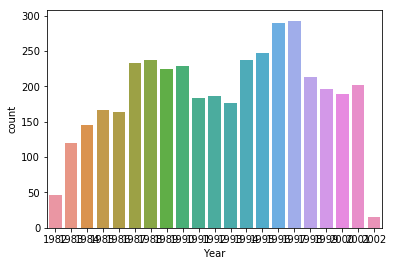

In [25]:
sns.countplot(x='Year', data=data)

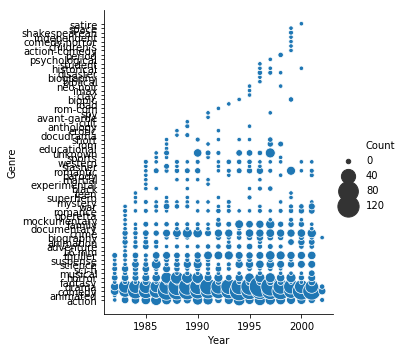

In [26]:
_d = data.groupby(['Year','Genre']).count().reset_index().rename(columns={'Title':'Count'})[['Year','Genre','Count']]

sns.relplot(x='Year', y='Genre', size='Count', data=_d, sizes=(20,450))

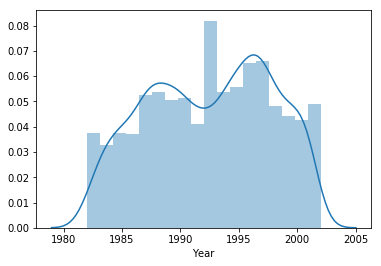

In [27]:
sns.distplot(data['Year'])

In [28]:
from sklearn.decomposition import NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, OneHotEncoder, FunctionTransformer,StandardScaler 

# Creating MegaPipeline to treat heterogeneous features

In [29]:
#Rememb
data.head()

,Year,Title,Origin,Genre,Plot
0,1982,Parasite,American,horror,"In the near future, an atomic disaster has red..."
1,1982,Partners,American,comedy,After a series of murders in Los Angeles's gay...
2,1982,Personal Best,American,drama,Chris Cahill is a young athlete who competes u...
3,1982,Poltergeist,American,horror,Steven and Diane Freeling live a quiet life in...
4,1982,Porky's,American,comedy,A group of Florida high school students plan o...


In [31]:
def get_text_features(dataframe):
    return dataframe[['Title','Plot']]

def get_categorical_data(dataframe):
    return pd.get_dummies(dataframe[['Origin','Genre']])

def get_numerical_data(dataframe):
    return dataframe[['Year']]

text_data = Pipeline([
    ('selector', FunctionTransformer(get_text_features, validate=False)),
    ('tfidf', TfidfVectorizer(token_pattern=r'\w+', ngram_range=(1,2))),
#     ('dimension_reduction', SelectKBest(chi2, k=300))
     ])
    
categorical_data = Pipeline([
    ('selector', FunctionTransformer(get_categorical_data, validate=False))
])
numerical_data = Pipeline([
    ('selector', FunctionTransformer(get_numerical_data, validate=False)),
    ('scaler', StandardScaler())    
])
    
feature_union = FeatureUnion(
    transformer_list=[
        ('text', text_data),
        ('numeric', numerical_data),
        ('categorical', categorical_data)
    ]
)
    
final_pipe = Pipeline([
    ('union', feature_union),
    ('nmf', NMF(n_components=5)),
    ('normalizer', Normalizer)
])
X = data.drop('Plot', axis=1)
plots = data['Plot'].tolist()

t = text_data.fit_transform(data)

In [32]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,2)
)
nmf  = NMF(n_components=5)
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

X = data.drop('Plot', axis=1)
plots = data['Plot'].tolist()

In [33]:
nmf_features = pipe.fit_transform(plots)
nmf_normalized = normalize(nmf_features)

NameError: name 'normalize' is not defined

In [ ]:
plot_recommendation_df = pd.DataFrame(nmf_normalized, index=data['Plot'])
plot_recommendation_df.head(3)

In [ ]:
_plot = """The film, just over a minute long, is composed of two shots. In the first, a girl sits at the base of an altar or tomb, her face hidden from the camera. At the center of the altar, a viewing portal displays the portraits of three U.S. Presidents—Abraham Lincoln, James A. Garfield, and William McKinley—each victims of assassination.\r\nIn the second shot, which runs just over eight seconds long, an assassin kneels feet of Lady Justice."""
plot = plot_recommendation_df.loc[_plot]
recommendations = plot_recommendation_df.dot(plot)

In [ ]:
recommendations.nlargest()

# Let's construct  a Class to make thing more easy to work with

In [ ]:
class WikiRecommender():
    
    def __init__(self, data, ngram_range=(1,2), n_components=10, max_features=5000, token_pattern=r'\w+', target="Plot"):
        self.ngram_range = ngram_range
        self.n_components = n_components
        self.max_features = max_features
        self.token_pattern = token_pattern
        self.data = data
        self.target = target
        
        
    def transform(self):
        vectorizer = TfidfVectorizer(
            ngram_range=self.ngram_range,
            max_features=self.n_components,
            token_pattern = self.token_pattern
        )
        nmf  = NMF(
            n_components=self.n_components
        )
        normalizer = Normalizer()
        pipe = Pipeline([
            ('tfidf', vectorizer),
            ('nmf', nmf),
            ('normalizer', normalizer)
        ])
        
        plots = self.data[self.target].tolist()
        return pipe.fit_transform(plots)
    
    @property
    def features(self):
        _features = self.transform()
        features = pd.DataFrame(_features, index=self.data[self.target])
        return features
    
    def recommend_based_on_plot(self, string='', n_recom=5):
        search = self.features.loc[string]
        recommendations = self.features.dot(search)
        return recommendations.nlargest(n_recom)
        

In [ ]:
recommender = WikiRecommender(data=data)
recommender.features

In [ ]:
recommender.recommend_based_on_plot(
    """A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]""",    n_recom = 10
)